#  Decision Trees


In [1]:
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report, mean_squared_error

%matplotlib inline

# Data Sample Load

Сегодня мы будем работать с [данными ](https://www.kaggle.com/c/titanic/data) о пассажирах Титаника.

    VARIABLE DESCRIPTIONS:
    survival        Survival
                (0 = No; 1 = Yes)
    pclass          Passenger Class
                (1 = 1st; 2 = 2nd; 3 = 3rd)
    name            Name
    sex             Sex
    age             Age
    sibsp           Number of Siblings/Spouses Aboard
    parch           Number of Parents/Children Aboard
    ticket          Ticket Number
    fare            Passenger Fare
    cabin           Cabin
    embarked        Port of Embarkation
                (C = Cherbourg; Q = Queenstown; S = Southampton)

    SPECIAL NOTES:
    Pclass is a proxy for socio-economic status (SES)
     1st ~ Upper; 2nd ~ Middle; 3rd ~ Lower

    Age is in Years; Fractional if Age less than One (1)
     If the Age is Estimated, it is in the form xx.5

Загрузим данные.

In [2]:
# data = pd.read_csv('titanic.csv')
data = pd.read_csv("https://grantmlong.com/data/titanic.csv")
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
data.Pclass.value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


Проведем небольшую предобработку данных: выкинем лишние колонки, закодируем категориальные переменные, выкинем строки в которых есть Nan.

In [5]:
def data_preprocessing(data_input):

    # Select bad columns and remove them
    cols_2_drop = ["PassengerId", "Ticket", "Cabin", "Name"]
    data_input = data_input.drop(cols_2_drop, axis=1)

    # Replace missing values (NaN) with -999 for 'Age' feature
    data_input.loc[:, "Age"] = data_input.Age.fillna(-999)

    # Encode 'Sex' values
    data_input.loc[:, "Sex"] = data_input.Sex.replace({"male": 0, "female": 1})

    # Remove all object with missing values
    data_input = data_input.dropna()

    # Encode categorical features using OneHotEncoding
    data_input = pd.get_dummies(data_input, columns=["Embarked"], prefix_sep="=")

    return data_input

In [6]:
data_preproc = data_preprocessing(data)

Намного лучше, теперь мы можем обучать на этих данных модель.

In [7]:
data_preproc.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked=C,Embarked=Q,Embarked=S
0,0,3,0,22.0,1,0,7.2500,0,0,1
1,1,1,1,38.0,1,0,71.2833,1,0,0
2,1,3,1,26.0,0,0,7.9250,0,0,1
3,1,1,1,35.0,1,0,53.1000,0,0,1
4,0,3,0,35.0,0,0,8.0500,0,0,1


In [8]:
data_preproc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 10 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    889 non-null    int64  
 1   Pclass      889 non-null    int64  
 2   Sex         889 non-null    int64  
 3   Age         889 non-null    float64
 4   SibSp       889 non-null    int64  
 5   Parch       889 non-null    int64  
 6   Fare        889 non-null    float64
 7   Embarked=C  889 non-null    uint8  
 8   Embarked=Q  889 non-null    uint8  
 9   Embarked=S  889 non-null    uint8  
dtypes: float64(2), int64(5), uint8(3)
memory usage: 58.2 KB


# EDA

Но сначала проведем небольшое EDA и посмотрим на распределение целевой переменной относительно разных признаков.


In [9]:
# Set up label column
y_column = "Survived"

# Select X columns
X_columns = data_preproc.columns[data_preproc.columns != y_column]

X_columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked=C',
       'Embarked=Q', 'Embarked=S'],
      dtype='object')

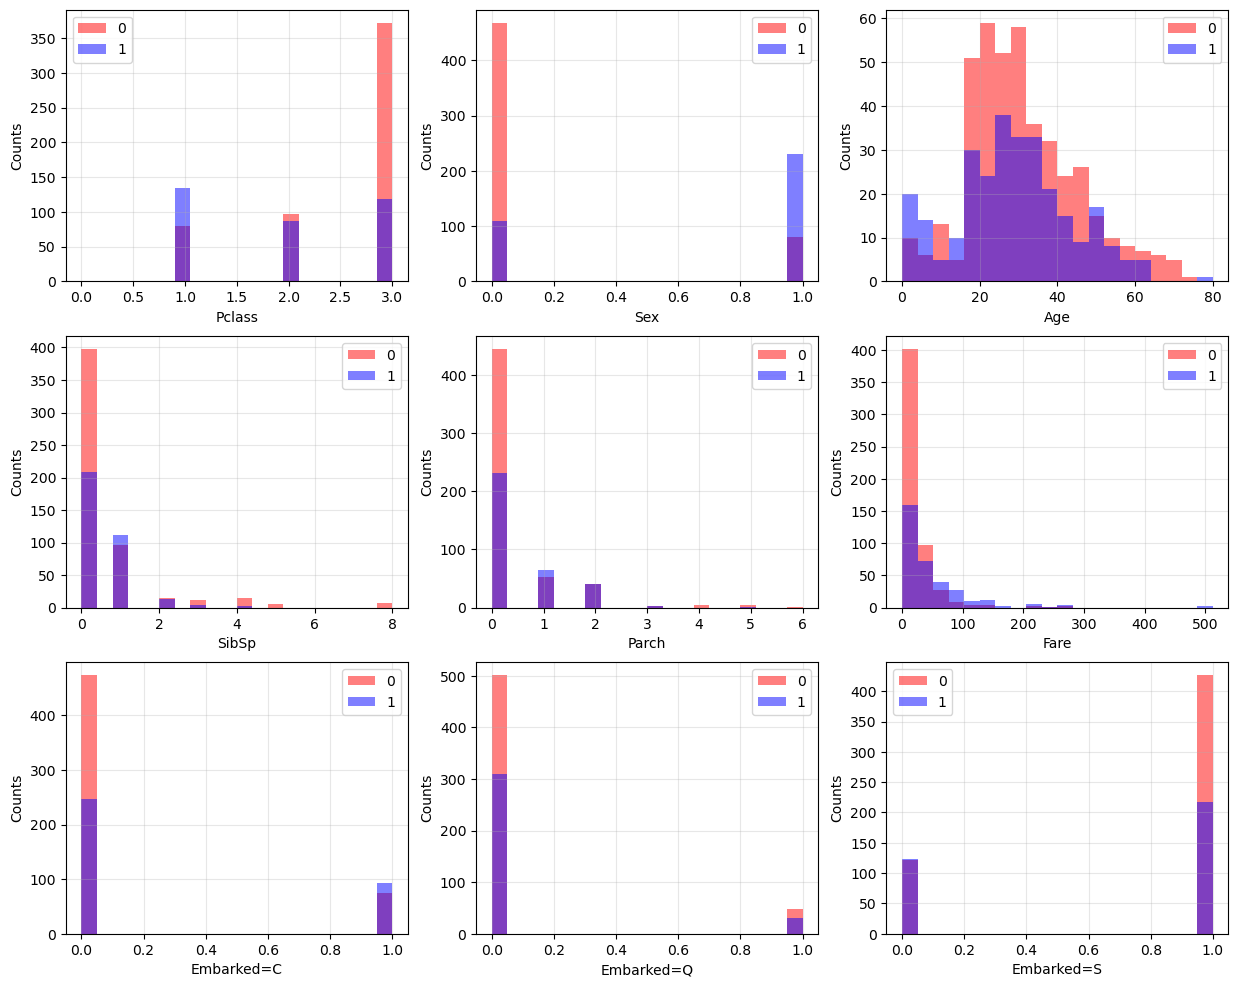

In [10]:
# Define size of the figure
plt.figure(figsize=(15, 12))

# For each column ...
for i_col in range(len(X_columns)):

    # Create subplot for each column
    plt.subplot(3, 3, i_col + 1)

    # Get column and label values
    x_col = data_preproc[X_columns[i_col]].values
    y_col = data_preproc[y_column].values

    # Plot histograms
    bins = np.linspace(0, x_col.max(), 21)
    plt.grid(alpha=0.3)
    plt.hist(x_col[y_col == 0], bins=bins, color="r", alpha=0.5, label="0")
    plt.hist(x_col[y_col == 1], bins=bins, color="b", alpha=0.5, label="1")

    # Labels and legend
    plt.xlabel(X_columns[i_col])
    plt.ylabel("Counts")
    plt.legend(loc="best")

plt.show();

## Data Split

Разобьем данные на train и test.

**Warning!** Не забываем фиксировать  `random_state`.

In [11]:
# import train_test_split function to split the sample
from sklearn.model_selection import train_test_split

X = data_preproc[X_columns].values
y = data_preproc[y_column].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=123  # 20% for test, 80% for train
)  # shuffle objects before split

# Решающее дерево 

**Решающее дерево (Decision Tree)** - это непараметрический ML-алгоритм, который относится к классу задач "Обучение с учителем".



Его идея состоит в том, чтобы разбивать обучающий датасет на все более и более мелкие подмножества, одновременно с этим строя дерево решений.


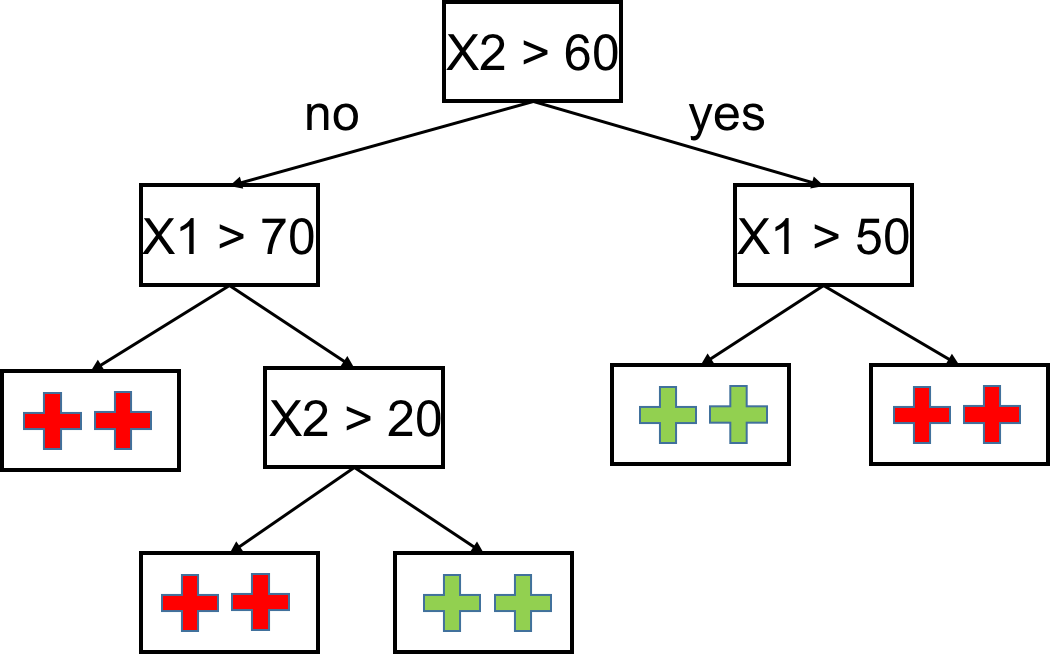

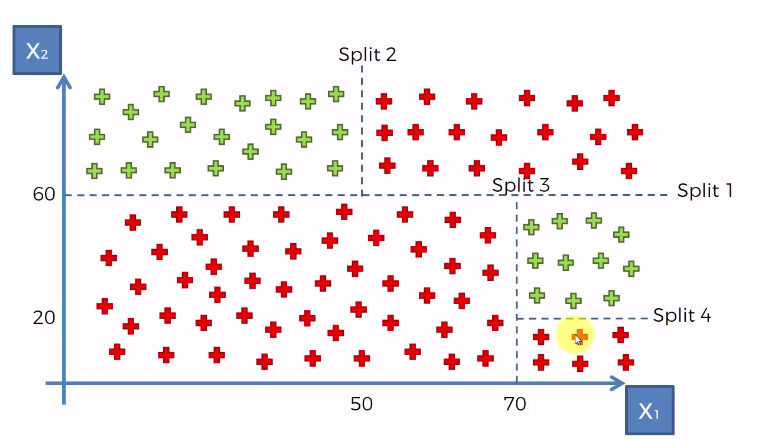

# Decision tree classifier
К счатью для нас, алгоритм дерева решений уже реализован в библиотеке sklearn. 
В данном случае, так как мы решаем задачу бинарной классификации, то воспользуемся классом `DecisionTreeClassifier`. 

    class sklearn.tree.DecisionTreeClassifier(*, criterion='gini', 
    splitter='best', max_depth=None, min_samples_split=2, min_samples_leaf=1, 
    min_weight_fraction_leaf=0.0, max_features=None, random_state=None, 
    max_leaf_nodes=None, min_impurity_decrease=0.0, min_impurity_split=None, 
    class_weight=None, ccp_alpha=0.0)

In [12]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(
    max_depth=10, min_samples_leaf=1, min_samples_split=2, criterion="gini"
)
clf.fit(X_train, y_train)
pred = clf.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.80      0.91      0.85       161
           1       0.82      0.66      0.73       106

    accuracy                           0.81       267
   macro avg       0.81      0.78      0.79       267
weighted avg       0.81      0.81      0.80       267



Всего три строчки кода, и мы обучили дерево решений!

## Визуализация решающих деревьев





In [13]:
import os
import tempfile

import graphviz
import pydotplus
from sklearn.tree import export_graphviz


# os.environ["PATH"] += os.pathsep + 'C:/Program Files (x86)/Graphviz2.38/bin/'
def plot_tree(model, cols):
    fname = tempfile.mkstemp(suffix=".png", prefix="decision_tree_")[1]
    dot_data = export_graphviz(
        model, filled=True, rounded=True, feature_names=cols, out_file=None
    )
    pydot_graph = pydotplus.graph_from_dot_data(dot_data)
    pydot_graph.write_png(fname)
    img = plt.imread(fname)
    plt.imshow(img)

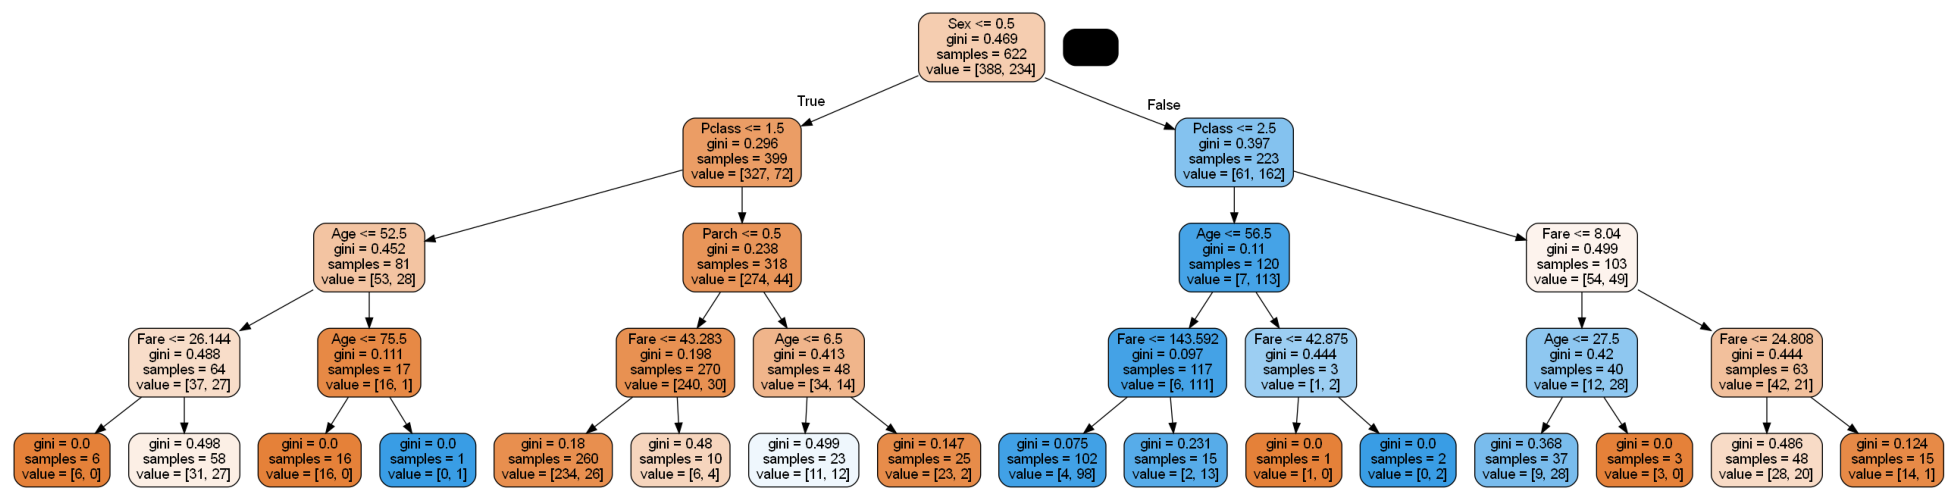

In [14]:
clf = DecisionTreeClassifier(max_depth=4, criterion="gini")
clf.fit(X_train, y_train)
plt.figure(figsize=(25, 25))
plt.axis("off")
plot_tree(clf, X_columns)

## Что не так с решающими деревьями?

Деревья решений обладают **high variance**. Даже небольшие изменения в обучающих данных могут приводить к существенным изменениям в структуре обученного дерева решений.

              precision    recall  f1-score   support

           0       0.81      0.88      0.84       166
           1       0.77      0.66      0.71       101

    accuracy                           0.80       267
   macro avg       0.79      0.77      0.78       267
weighted avg       0.80      0.80      0.79       267



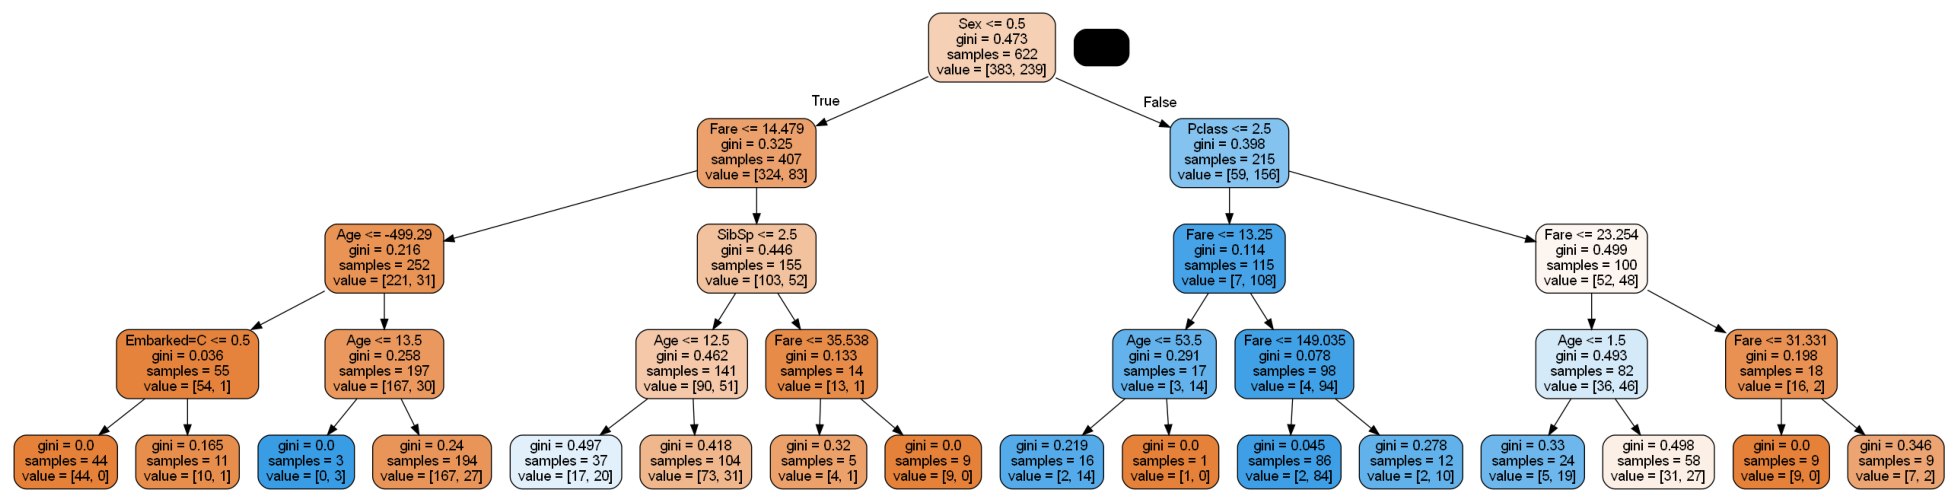

In [15]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=1  # 20% for test, 80% for train
)  # shuffle objects before split

clf1 = DecisionTreeClassifier(max_depth=4, criterion="gini")
clf1.fit(X_train, y_train)
plt.figure(figsize=(25, 25))
plt.axis("off")
plot_tree(clf1, X_columns)
pred = clf1.predict(X_test)

print(classification_report(y_test, pred))

In [16]:
data_preproc.drop("Survived", axis=1).columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked=C',
       'Embarked=Q', 'Embarked=S'],
      dtype='object')

In [17]:
clf.feature_importances_

array([0.20237003, 0.58283713, 0.09390451, 0.        , 0.01815784,
       0.10273049, 0.        , 0.        , 0.        ])

Мы просто поменяли `random_seed` для `train_test_split`, а дерево получилось уже совсем другое!


# Оптимизация гиперпараметров

**Recap:** чем параметры отличаются от гиперпараметров?

Давайте подберем оптимальный набор гиперпараметров для нашей модели. Для этого воспользуемся методом GridSearch на кросс-валидации. Будем использовать метод  `GridSearchCV` из библиотеки sklearn.

In [18]:
# Import GridSearchCV class
from sklearn.model_selection import GridSearchCV

# Define Decision Tree classifier with default parameters
clf = DecisionTreeClassifier()

# Estimate grid of the classifier hyperparameters
parameters = {
    "max_depth": [1, 3, 5, 7, 10],
    "min_samples_split": [2, 5, 10, 20],
    "min_samples_leaf": [1, 5, 10, 50],
}

# Define GridSearch parameters
gs = GridSearchCV(
    clf,  # Classifier object to optimize
    parameters,  # Grid of the hyperparameters
    scoring="accuracy",  # Claasification quality metric to optimize
    cv=3,
)  # Number of folds in KFolds cross-validation (CV)


# Run Grid Search optimization
gs.fit(X_train, y_train)
gs.best_params_

{'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 2}

In [19]:
pred = gs.predict(X_test)
print(classification_report(y_test, pred))

              precision    recall  f1-score   support

           0       0.85      0.92      0.88       166
           1       0.84      0.73      0.78       101

    accuracy                           0.85       267
   macro avg       0.85      0.82      0.83       267
weighted avg       0.85      0.85      0.84       267



Отлично! Качество возросло!